In [8]:
import pandas as pd
import json
import os
from plots import *

print(os.getcwd())
#print(os.chdir('/Users/soren/Work/autolr'))
print(os.chdir('C:\\Users\\lamec\\WORK\\autolr'))
print(os.getcwd())

parameter_file = 'parameters/imagenet.yml'
from sge.parameters import load_parameters, params
phen_params = (None, params)
load_parameters(parameter_file)
from utils.smart_phenotype import readable_phenotype, smart_phenotype
from utils.visualization_tools import *


C:\Users\lamec\WORK\autolr
None
C:\Users\lamec\WORK\autolr
using  parameters/imagenet.yml for parameters


In [9]:
run_number = range(1, 33)
#task = "tensorflow"
folder = "C:\\Users\\lamec\\WORK\\autolr\\results\\arch_optimizers_results"
folder = "C:\\Users\\lamec\\WORK\\autolr\\results\\arch_optimizers_results\\STEFANO EXPERIMENTS FM"
#folder = '/Users/soren/Work/autolr/results/arch_optimizer'
# Create the DataFrame with ified columns and data types
df = pd.DataFrame({
    'experiment_name': pd.Series(dtype='string'),
    'run_number': pd.Series(dtype='string'),
    'genetic_id': pd.Series(dtype='int64'),
    'phenotype': pd.Series(dtype='string'),
    'smart_phenotype': pd.Series(dtype='string'),
    'fitness': pd.Series(dtype='float64'),
	'duration': pd.Series(dtype='float64'),
	'source': pd.Series(dtype='string'),
    'operation': pd.Series(dtype='string'),
})


df = load_results(folder)

#archive = json.load(open('C:\\Users\\lamec\\WORK\\autolr\\results\\arch_optimizers_results\\resnet\\run_8\\z-archive_144.json'))\
df['fitness'] = df['fitness'] * -1
archive = {}
for ix, row in df.iterrows():
    if row['smart_phenotype'] not in archive:
        archive[row['smart_phenotype']] = {'id': len(archive), 'phenotype': row['phenotype'], 'fitness': row['fitness']}

In [10]:
def get_parents_id_new_archive(x):
    if x is None:
        print("uh oh")
    print(x['parents'])
    if x['parents'] is None or None in x['parents']:
        return x
    updated_parents = []
    try:
        p1_new_id = archive[df[df['genetic_id'] == int(x['parents'][0])]['smart_phenotype'].item()]['id']
        updated_parents.append(p1_new_id)
    except:
        updated_parents.append(None)
    try:
        p2_new_id = archive[df[df['genetic_id'] == int(x['parents'][1])]['smart_phenotype'].item()]['id']
        updated_parents.append(p2_new_id)
    except:
        updated_parents.append(None)
    x['parents'] = updated_parents
    return x['parents']
#df['parents'] = df.apply(get_parents_id_new_archive, axis=1)
individual_counts = df.groupby(['experiment_name', 'run_number'])['genetic_id'].nunique().reset_index(name='Unique Individual Count')
df['generation'] = df['generation'].astype(int)
if 'source' in df.columns:
    df['source'] = df['source'].apply(lambda x: 'archive' if x == 'elitism' else x)
df['behavior_id'] = df['smart_phenotype'].apply(lambda x: archive[x]['id'])
if 'source' in df.columns and 'operation' in df.columns:
    df['source+operation'] = df.apply(lambda row: str(row['source']) + ' + ' + str(row['operation']), axis=1)
best_fitness_generations = []
highest_fitness = float('-inf')

for _, row in df.sort_values('generation').iterrows():
    if row['fitness'] > highest_fitness:
        highest_fitness = row['fitness']
        best_fitness_generations.append(row['generation'])
        print(f"behavior_id: {row['behavior_id']}, generation: {row['generation']}, fitness: {row['fitness']}")
df.head(5)

behavior_id: 1760, generation: 0, fitness: -0.0
behavior_id: 139, generation: 0, fitness: 0.20908889174461365
behavior_id: 3786, generation: 0, fitness: 0.8637555837631226
behavior_id: 12470, generation: 0, fitness: 0.8763999938964844
behavior_id: 13702, generation: 0, fitness: 0.880911111831665
behavior_id: 3274, generation: 1, fitness: 0.8840222358703613
behavior_id: 118852, generation: 1, fitness: 0.8874222040176392
behavior_id: 33122, generation: 5, fitness: 0.8884666562080383
behavior_id: 79149, generation: 31, fitness: 0.8902888894081116
behavior_id: 100251, generation: 34, fitness: 0.8920221924781799
behavior_id: 234011, generation: 50, fitness: 0.8926888704299927
behavior_id: 186438, generation: 62, fitness: 0.8935111165046692


,experiment_name,run_number,genetic_id,generation,phenotype,smart_phenotype,fitness,operation,parents,genotype,loss,accuracy,val_loss,val_accuracy,behavior_id
0,FM,run_1,322,9,"alpha_func, beta_func, sigma_func, grad_func =...","divide_no_nan(grad, add(constant(9.98279874e-0...",0.880222,elitism,"[246, 212]","[[0], [1], [], [0], [81], [1], [], [3], [], [0...","[1.6664284467697144, 0.9256548285484314, 0.763...","[0.4481739103794098, 0.664695680141449, 0.7117...","[0.8483279347419739, 0.6996541619300842, 0.625...","[0.6959999799728394, 0.7419999837875366, 0.761...",0
1,FM,run_1,599,9,"alpha_func, beta_func, sigma_func, grad_func =...","multiply(constant(9.99916780e-01), grad)",0.787489,crossover,"[599, 3]","[[0], [1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1], [9...",NaN,NaN,NaN,NaN,1
2,FM,run_1,3,9,"alpha_func, beta_func, sigma_func, grad_func =...",grad,0.385289,mutation,"[3, 3]","[[0], [0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1], [1...",NaN,NaN,NaN,NaN,2
3,FM,run_1,3,9,"alpha_func, beta_func, sigma_func, grad_func =...",grad,0.385289,crossover,"[3, 3]","[[0], [1, 1, 0, 1, 0, 1, 0, 0, 1, 1], [7, 3, 5...",NaN,NaN,NaN,NaN,2
4,FM,run_1,3,9,"alpha_func, beta_func, sigma_func, grad_func =...",grad,0.385289,mutation,"[3, 3]","[[0], [0, 1, 1, 1, 0, 0, 0, 1, 1, 1], [4, 5, 9...",NaN,NaN,NaN,NaN,2


In [11]:
df_crossover = df[df['operation'] == 'crossover']
df_crossover['parents']

1            [599, 3]
3              [3, 3]
6              [3, 3]
20             [3, 3]
27             [3, 3]
              ...    
1236795    [146, 183]
1236796     [188, 78]
1236797     [185, 91]
1236798    [138, 109]
1236799     [123, 46]
Name: parents, Length: 618153, dtype: object

In [12]:
df_crossover = df[df['operation'] == 'crossover']
df_crossover['parent_1'] = df_crossover['parents'].apply(lambda x: int(x[0]))
df_crossover['parent_2'] = df_crossover['parents'].apply(lambda x: int(x[1]))
for ix, row in df_crossover.iterrows():
    #print(df[df['genetic_id'] == row['parent_2']]['phenotype'])
    p1_phenotype = df[df['genetic_id'] == row['parent_1']]['phenotype'].head(1).item()
    p2_phenotype = df[df['genetic_id'] == row['parent_2']]['phenotype'].head(1).item()

    print(f"Child: {row['genetic_id']} Readable Phenotype: {readable_phenotype(row['phenotype'])}")
    print(f"P1: {row['parent_1']} Readable Phenotype: {readable_phenotype(p1_phenotype)}")
    print(f"P2: {row['parent_2']} Readable Phenotype: {readable_phenotype(p2_phenotype)}")
    print("--------\n\n")

    


C:\Users\lamec\AppData\Local\Temp\ipykernel_9768\1306065707.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_crossover['parent_1'] = df_crossover['parents'].apply(lambda x: int(x[0]))
C:\Users\lamec\AppData\Local\Temp\ipykernel_9768\1306065707.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_crossover['parent_2'] = df_crossover['parents'].apply(lambda x: int(x[1]))


IndexError: list index out of range

In [16]:
df.to_csv('all_results.csv', index=False)
df_crossover.to_csv('crossover_results.csv', index=False)
df_mutation.to_csv('mutation_results.csv', index=False)

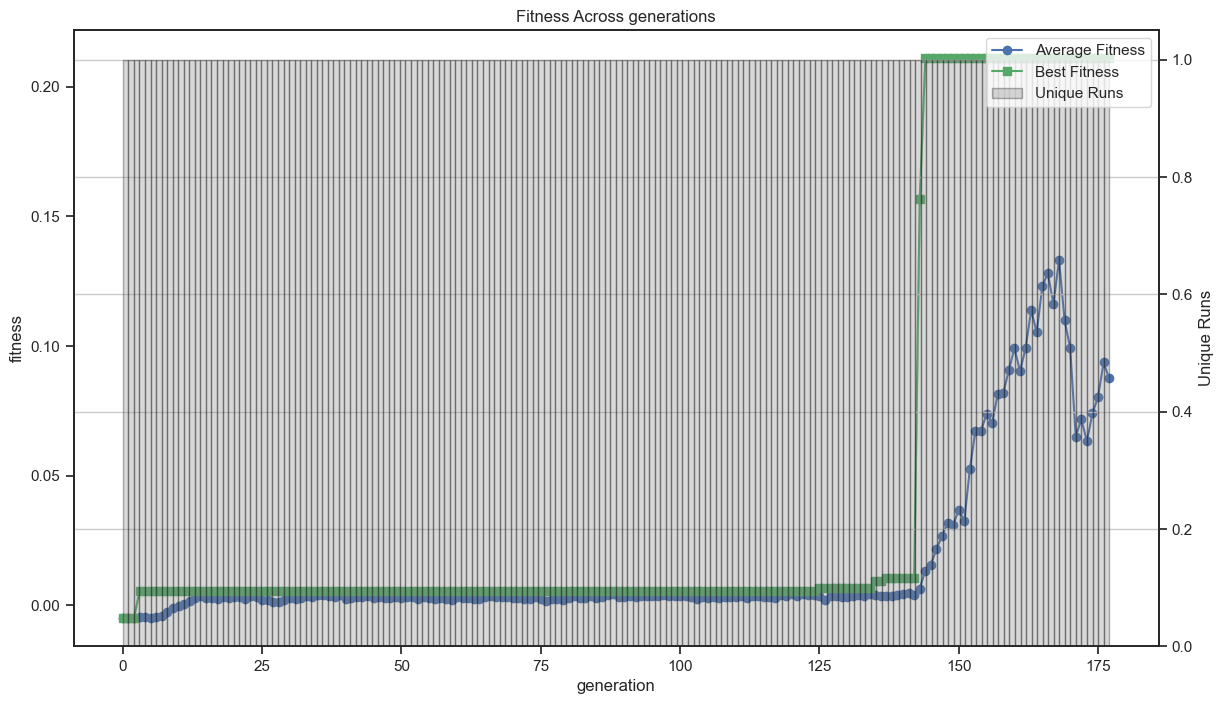

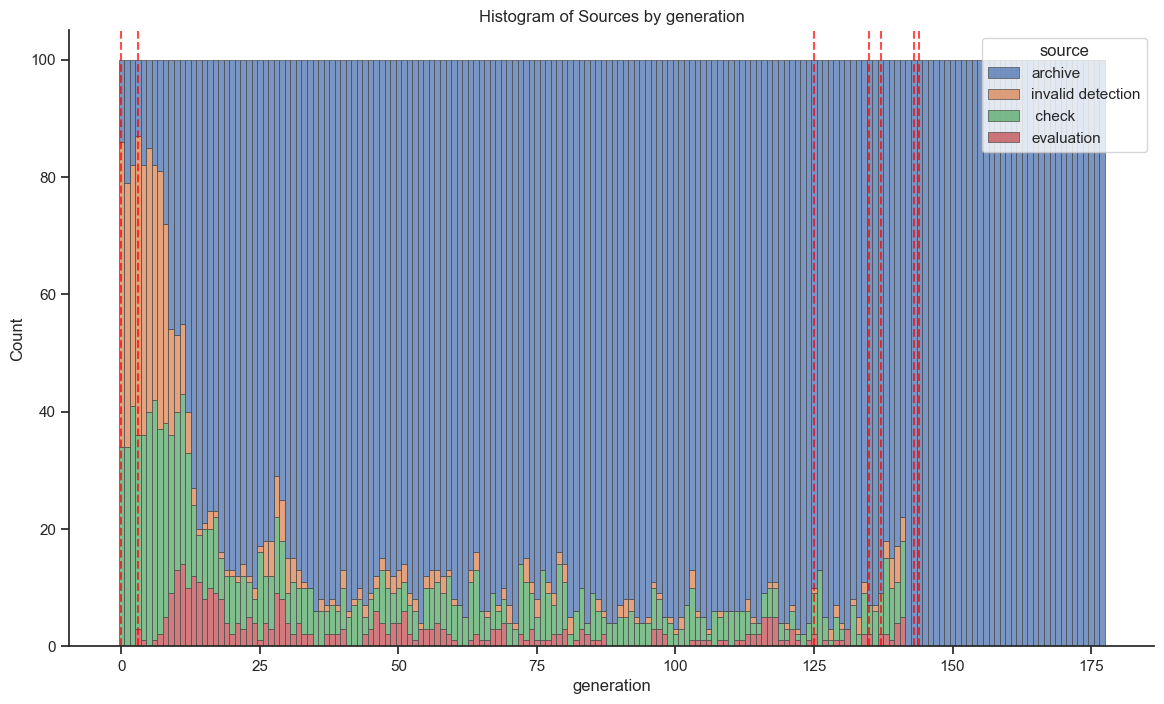

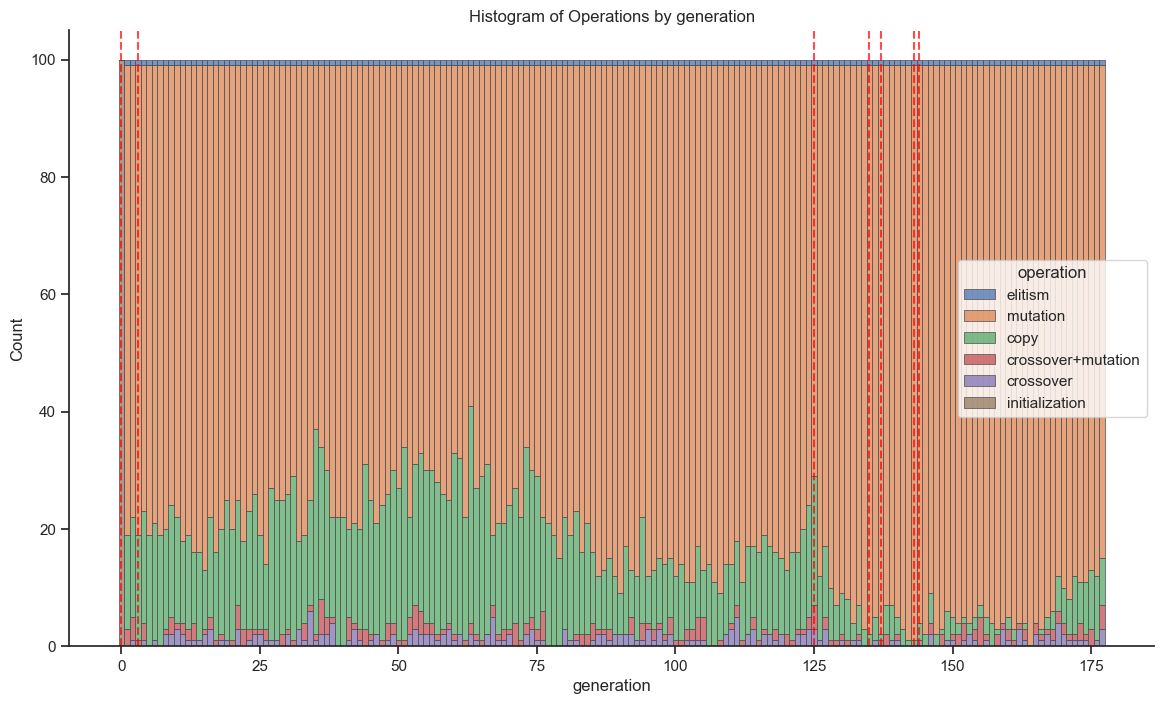


Combined count and percentage display:
source                    check        archive  evaluation invalid detection
operation                                                                   
copy                 111 (4.5%)   2258 (91.5%)   37 (1.5%)         61 (2.5%)
crossover              1 (0.5%)    217 (98.2%)    0 (0.0%)          3 (1.4%)
crossover+mutation    16 (6.4%)    228 (91.6%)    0 (0.0%)          5 (2.0%)
elitism                0 (0.0%)   177 (100.0%)    0 (0.0%)          0 (0.0%)
initialization       34 (34.0%)     14 (14.0%)    0 (0.0%)        52 (52.0%)
mutation            1047 (7.2%)  12695 (87.0%)  313 (2.1%)        531 (3.6%)
  experiment_name run_number  genetic_id generation  \
0          resnet      run_9         362         99   
1          resnet      run_9        9802         99   
2          resnet      run_9        9803         99   
3          resnet      run_9        9804         99   
4          resnet      run_9        9805         99   

             

ValueError: Could not interpret value `Source+Operation` for `hue`. An entry with this name does not appear in `data`.

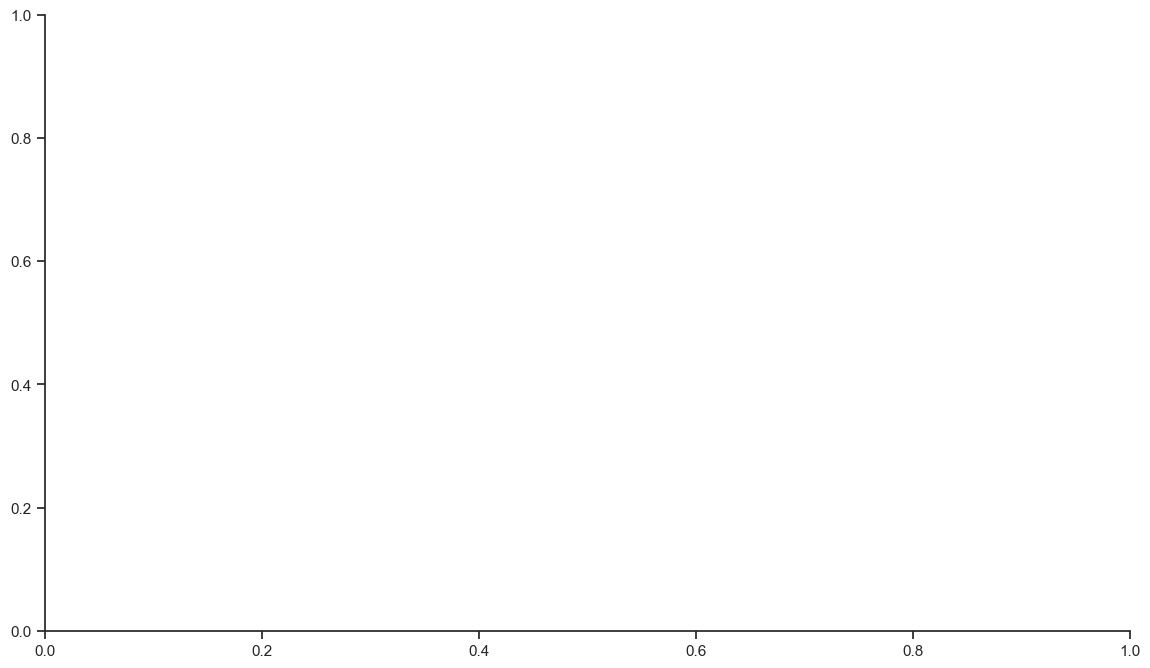

In [ ]:
#df = df[df['experiment_name'] == 'SMX']
plot_fitness_and_unique_runs(df)
plot_sources_per_generation(df, best_fitness_generations)
plot_operations_per_generation(df, best_fitness_generations)
print_sources_per_operation(df)
#plot_grouped_stacked_histogram(df, 10, 10, 15)
#plot_percentile_grouped_stacked_histogram(df)
plot_operation_and_sources_per_generation(df)
plot_crossover_type(df, best_fitness_generations)
plot_mutation_type(df, best_fitness_generations)
df

In [ ]:
#df_mutation = get_mutation_df(df)
df_crossover = get_crossover_df(df)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

df_crossover = df_crossover[df_crossover['crossover_type'] == 'Destructive']
# Calculate parent fitness averages and difference for each crossover
def get_crossover_fitness_diff(df, df_crossover):
    parent_avg_fitness = []
    fitness_diff = []

    for _, row in df_crossover.iterrows():
        # Get parent fitness values
        p1_fit = df[df['genetic_id'] == row['parent_1']]['fitness']
        p2_fit = df[df['genetic_id'] == row['parent_2']]['fitness']
        # Use .head(1) to avoid duplicates, .item() to get value
        p1_fit = p1_fit.head(1).item() if not p1_fit.empty else np.nan
        p2_fit = p2_fit.head(1).item() if not p2_fit.empty else np.nan
        avg_fit = np.nanmean([p1_fit, p2_fit])
        parent_avg_fitness.append(avg_fit)
        fitness_diff.append(row['fitness'] - avg_fit)

    df_crossover = df_crossover.copy()
    df_crossover['parent_avg_fitness'] = parent_avg_fitness
    df_crossover['fitness_diff'] = fitness_diff
    return df_crossover

df_crossover = get_crossover_fitness_diff(df, df_crossover)
# Visualization
mean_diff = np.nanmean(df_crossover['fitness_diff'])
std_diff = np.nanstd(df_crossover['fitness_diff'])

plt.figure(figsize=(10, 6))
plt.hist(df_crossover['fitness_diff'].dropna(), bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(mean_diff, color='red', linestyle='--', label=f'Mean: {mean_diff:.4f}')
plt.axvline(mean_diff + std_diff, color='green', linestyle=':', label=f'+1 Std: {mean_diff + std_diff:.4f}')
plt.axvline(mean_diff - std_diff, color='green', linestyle=':', label=f'-1 Std: {mean_diff - std_diff:.4f}')
plt.title(f'Distribution of Fitness Difference After Crossover\nMean fitness difference: {mean_diff:.4f}\nStd fitness difference: {std_diff:.4f}')
plt.xlabel('Fitness Difference')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df

In [ ]:
df_mutation = get_mutation_df(df)
df_mutation = df_mutation[df_mutation['mutation_type'] == "Destructive"]
print(f"Found {len(df_mutation)} Destructive mutations")
count = 0
for ix, row in df_mutation.iterrows():
    p1_smart_phenotype = df[df['genetic_id'] == row['parent_1']]['smart_phenotype'].head(1).item()
    #p2_smart_phenotype = df[df['genetic_id'] == row['parent_2']]['smart_phenotype'].head(1).item()
    p1_phenotype = df[df['genetic_id'] == row['parent_1']]['phenotype'].head(1).item()
    #p2_phenotype = df[df['genetic_id'] == row['parent_2']]['phenotype'].head(1).item()
    c_archive_id = archive[row['smart_phenotype']]['id']
    p1_archive_id = archive[p1_smart_phenotype]['id']
    #p2_archive_id = archive[p2_smart_phenotype]['id']
    p1_fit = archive[p1_smart_phenotype]['fitness']
    #p2_fit = archive[p2_smart_phenotype]['fitness']
    p1_genotype = df[df['genetic_id'] == row['parent_1']]['genotype'].head(1).item()
    #p2_genotype = df[df['genetic_id'] == row['parent_2']]['genotype'].head(1).item()



    print(f"[GEN: {row['generation']} BID:{c_archive_id} FIT:{row['fitness']}]Child: {row['genetic_id']} Phenotype:\n {readable_phenotype(row['phenotype'])}")
    #print(f"[BID:{p1_archive_id} FIT:{p1_fit}]P1: {row['parent_1']} Phenotype:\n {readable_phenotype(p1_phenotype)}")
    #print(f"[BID:{p2_archive_id} FIT:{p2_fit}]P2: {row['parent_2']} Phenotype:\n {readable_phenotype(p2_phenotype)}")

    #for c_g, p1_g in zip(row['genotype'], p1_genotype):
    #    print(f"{c_g} {p1_g}")
    #print("--------\n\n")